# Regresion Basica: Predecir eficiencia de gasolina

Este libro usa el set de datos clasico [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) y construye un modelo para predecir el consumo de vehiculos de 1970 y 1980. Para hacer esto proveeremos el modelo con una descripcion de muchos automoviles de ese periodo. Esta descripcion incluye atributos como: Cilindros, desplazamiento, potencia y peso.

El objetivo de este ejercicio es predecir el target miles per galon (MPG), que vendría a representar las millas por galón de combustible.

Este ejemplo usa el API `tf.keras` , revise [Esta Guia](https://www.tensorflow.org/guide/keras) para obtener mas detalles.

In [1]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2025-03-14 08:46:12.343960: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.16.2


In [2]:
import numpy as np

## El set de Datos de MPG

El set de datos esta disponible de el siguiente repositorio [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/).

### Obtenga los datos
Primero descargue el set de datos.

In [3]:

# 1. Descargar el dataset
dataset_path = keras.utils.get_file(
    "auto-mpg.data",
    "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
)
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin', 'Car Name']

raw_dataset = pd.read_csv(
    dataset_path, 
    names=column_names, 
    na_values='?', 
    comment='\t', 
    sep=' ', 
    skipinitialspace=True
)

print("Forma de raw_dataset:", raw_dataset.shape)
print(raw_dataset.head())

'/Users/aidamarquez/.keras/datasets/auto-mpg.data'

Importelo usando pandas.

In [4]:
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin', 'Car Name']

In [5]:
print(type(dataset_path))  # Debería ser <class 'str'>


<class 'str'>


In [6]:
with open(dataset_path, "r") as f:
    for _ in range(5):  # Lee las primeras 5 líneas
        print(f.readline())


18.0   8   307.0      130.0      3504.      12.0   70  1	"chevrolet chevelle malibu"

15.0   8   350.0      165.0      3693.      11.5   70  1	"buick skylark 320"

18.0   8   318.0      150.0      3436.      11.0   70  1	"plymouth satellite"

16.0   8   304.0      150.0      3433.      12.0   70  1	"amc rebel sst"

17.0   8   302.0      140.0      3449.      10.5   70  1	"ford torino"



In [7]:
import os
print(os.path.exists(dataset_path))


True


In [10]:
print("column_names:", column_names)
print("Tipo de column_names:", type(column_names))
for i, col in enumerate(column_names):
    print(f"Elemento {i}: {col} - tipo: {type(col)}")


column_names: ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin', 'Car Name']
Tipo de column_names: <class 'list'>
Elemento 0: MPG - tipo: <class 'str'>
Elemento 1: Cylinders - tipo: <class 'str'>
Elemento 2: Displacement - tipo: <class 'str'>
Elemento 3: Horsepower - tipo: <class 'str'>
Elemento 4: Weight - tipo: <class 'str'>
Elemento 5: Acceleration - tipo: <class 'str'>
Elemento 6: Model Year - tipo: <class 'str'>
Elemento 7: Origin - tipo: <class 'str'>
Elemento 8: Car Name - tipo: <class 'str'>


In [11]:
columns_index = pd.Index(['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin', 'Car Name'],dtype="object")
columns_index

Index(['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
       'Acceleration', 'Model Year', 'Origin', 'Car Name'],
      dtype='object')

In [65]:
import numpy as np
print(np.__version__)


1.24.3


In [69]:
# 2. Limpiar o rellenar valores faltantes
# Opción A: Eliminar filas con NaN
# dataset = raw_dataset.dropna()
# print("Forma de dataset después de dropna():", dataset.shape)

# Opción B: Rellenar valores faltantes en 'Horsepower'
dataset = raw_dataset.copy()
dataset['Horsepower'] = pd.to_numeric(dataset['Horsepower'], errors='coerce')
dataset['Horsepower'].fillna(dataset['Horsepower'].median(), inplace=True)
print("Forma de dataset después de fillna():", dataset.shape)

# Eliminar la columna 'Car Name'
dataset = dataset.drop('Car Name', axis=1)

Forma de raw_dataset: (398, 9)
    MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
0  18.0          8         307.0       130.0  3504.0          12.0   
1  15.0          8         350.0       165.0  3693.0          11.5   
2  18.0          8         318.0       150.0  3436.0          11.0   
3  16.0          8         304.0       150.0  3433.0          12.0   
4  17.0          8         302.0       140.0  3449.0          10.5   

   Model Year  Origin  Car Name  
0          70       1       NaN  
1          70       1       NaN  
2          70       1       NaN  
3          70       1       NaN  
4          70       1       NaN  
Forma de dataset después de fillna(): (398, 9)


/var/folders/zl/x4wcpc6n7p75fkkmssl2_0vh0000gn/T/ipykernel_23828/463306606.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataset['Horsepower'].fillna(dataset['Horsepower'].median(), inplace=True)


In [70]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           398 non-null    float64
 1   Cylinders     398 non-null    int64  
 2   Displacement  398 non-null    float64
 3   Horsepower    398 non-null    float64
 4   Weight        398 non-null    float64
 5   Acceleration  398 non-null    float64
 6   Model Year    398 non-null    int64  
 7   Origin        398 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 25.0 KB


In [71]:
dataset.describe(include='all')

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.304020,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,38.222625,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,76.000000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,125.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


### Limpia los datos

Trata los missings y variables categóricas

In [72]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [19]:
dataset = dataset[dataset['Horsepower']!='?']
dataset['Horsepower'] = dataset['Horsepower'].astype(float)

In [74]:
print(dataset.dtypes)


MPG             float64
Cylinders         int64
Displacement    float64
Horsepower      float64
Weight          float64
Acceleration    float64
Model Year        int64
Origin            int64
dtype: object


In [76]:
# se puede hacer con get_dummies
origin = dataset.pop('Origin')

dataset['USA'] = (origin == 1)*1
dataset['Europe'] = (origin == 2)*1
dataset['Japan'] = (origin == 3)*1

In [77]:
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,0,0
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,0,0
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,0,0
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,0,0
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,0,0


### Divide los datos en train y test

Ahora divida el set de datos en un set de entrenamiento y otro de pruebas. 80% para entrenamiento

Usaremos el set de pruebas en la evaluacion final de nuestro modelo.

NOTA: El resultado tienen que ser dos datasets

In [78]:
train_dataset = dataset.sample(frac=0.8, random_state = 0)
test_dataset = dataset.drop(train_dataset.index)

### Inspecciona los datos

Revise rapidamente la distribucion conjunta del dataset de entrenamiento mediante un grid de gráficos

In [79]:
train_dataset.columns

Index(['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
       'Acceleration', 'Model Year', 'USA', 'Europe', 'Japan'],
      dtype='object')

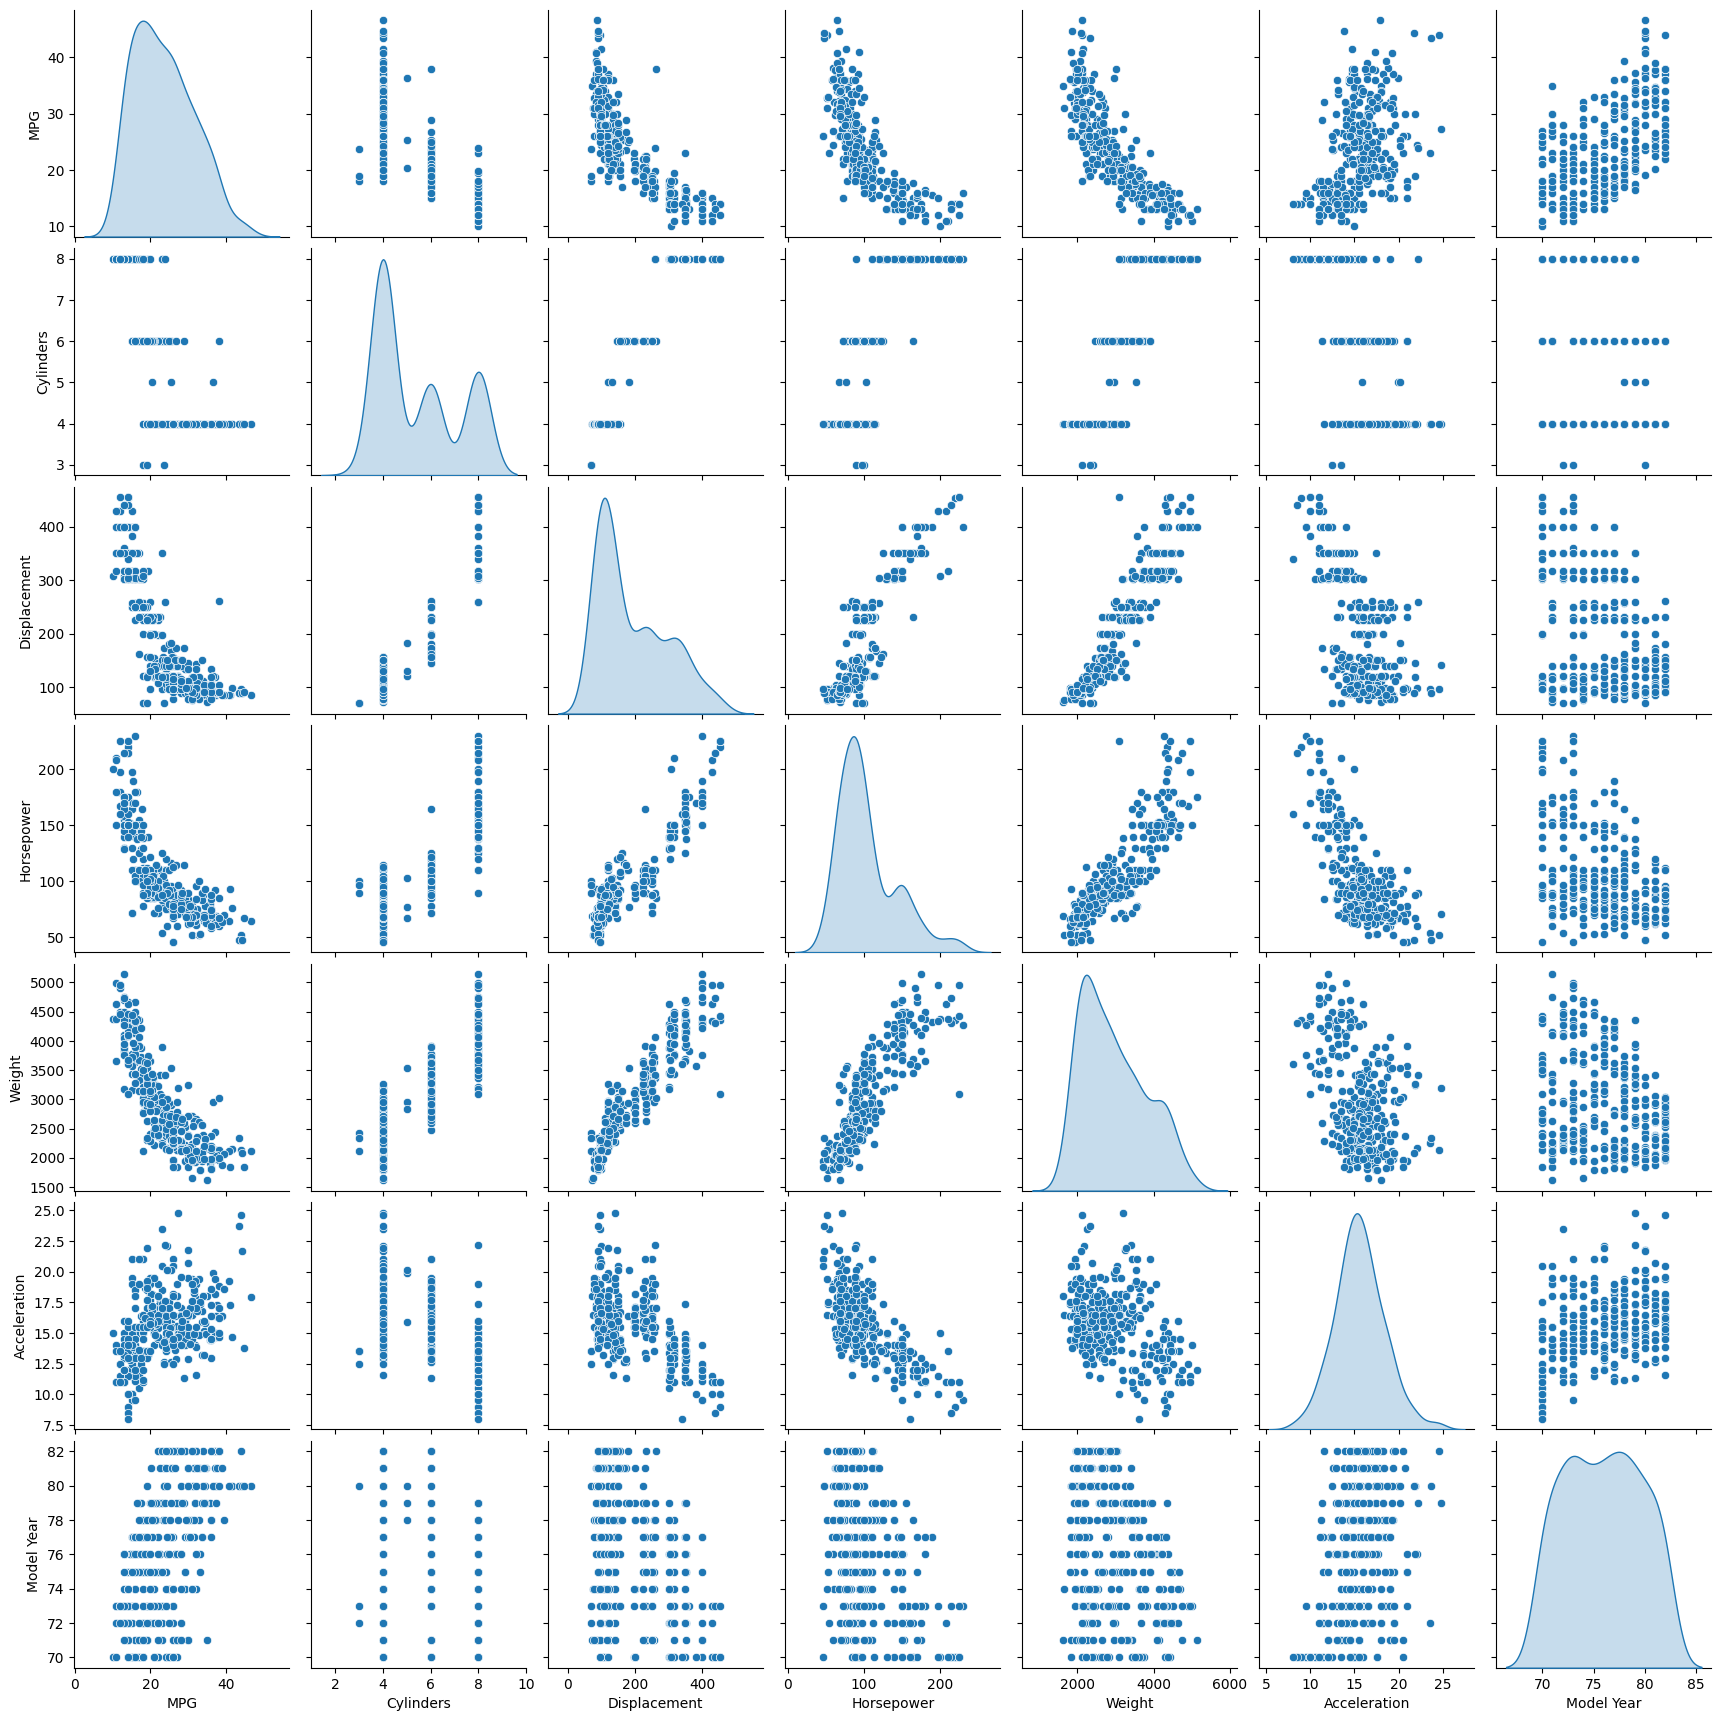

In [80]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
       'Acceleration', 'Model Year']], diag_kind = 'kde')

Tambien revise las estadisticas generales:

In [81]:
train_dataset.describe()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
count,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000
mean,23.590566,5.427673,193.061321,103.900943,2963.823899,15.595912,75.946541,0.641509,0.163522,0.194969
std,7.913617,1.682941,103.812742,38.391029,844.749805,2.796282,3.705266,0.480313,0.370424,0.396801
min,10.000000,3.000000,70.000000,46.000000,1613.000000,8.000000,70.000000,0.000000,0.000000,0.000000
25%,17.125000,4.000000,100.250000,75.250000,2219.250000,13.900000,73.000000,0.000000,0.000000,0.000000
50%,22.750000,4.000000,151.000000,92.000000,2792.500000,15.500000,76.000000,1.000000,0.000000,0.000000
75%,29.000000,6.000000,259.500000,120.000000,3571.250000,17.300000,79.000000,1.000000,0.000000,0.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,1.000000,1.000000,1.000000


In [82]:
train_dataset["MPG"] = pd.to_numeric(train_dataset["MPG"], errors="coerce")




In [83]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.T
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,318.0,5.427673,1.682941,3.0,4.00,4.0,6.00,8.0
Displacement,318.0,193.061321,103.812742,70.0,100.25,151.0,259.50,455.0
Horsepower,318.0,103.900943,38.391029,46.0,75.25,92.0,120.00,230.0
Weight,318.0,2963.823899,844.749805,1613.0,2219.25,2792.5,3571.25,5140.0
Acceleration,318.0,15.595912,2.796282,8.0,13.90,15.5,17.30,24.8
Model Year,318.0,75.946541,3.705266,70.0,73.00,76.0,79.00,82.0
USA,318.0,0.641509,0.480313,0.0,0.00,1.0,1.00,1.0
Europe,318.0,0.163522,0.370424,0.0,0.00,0.0,0.00,1.0
Japan,318.0,0.194969,0.396801,0.0,0.00,0.0,0.00,1.0


### Separa las features del target

Separe el target de las features.

In [84]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

label_mean = train_labels.mean()
label_std = train_labels.std()
normed_train_labels = (train_labels - label_mean) / label_std
# Si tienes un conjunto de test, haz lo mismo con él.


### Estandariza los datos

Es una buena práctica estandarizar funciones que utilizan diferentes escalas y rangos. Aunque el modelo podría converger sin estandarizar, dificulta el entrenamiento y hace que el modelo resultante dependa de la elección de las unidades utilizadas en la entrada.

In [85]:
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,318.0,5.427673,1.682941,3.0,4.00,4.0,6.00,8.0
Displacement,318.0,193.061321,103.812742,70.0,100.25,151.0,259.50,455.0
Horsepower,318.0,103.900943,38.391029,46.0,75.25,92.0,120.00,230.0
Weight,318.0,2963.823899,844.749805,1613.0,2219.25,2792.5,3571.25,5140.0
Acceleration,318.0,15.595912,2.796282,8.0,13.90,15.5,17.30,24.8
Model Year,318.0,75.946541,3.705266,70.0,73.00,76.0,79.00,82.0
USA,318.0,0.641509,0.480313,0.0,0.00,1.0,1.00,1.0
Europe,318.0,0.163522,0.370424,0.0,0.00,0.0,0.00,1.0
Japan,318.0,0.194969,0.396801,0.0,0.00,0.0,0.00,1.0


In [86]:
def norm(x):
    # Reemplazar los valores de std que sean 0 por 1 para evitar división por cero
    std_adj = train_stats['std'].replace(0, 1)
    return (x - train_stats['mean']) / std_adj

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

print(normed_train_data.shape)
print(normed_test_data.shape)


(318, 9)
(80, 9)


In [87]:
normed_train_data = normed_train_data.astype('float32')
normed_test_data = normed_test_data.astype('float32')
train_labels = train_labels.astype('float32')
test_labels = test_labels.astype('float32')

Estos datos estandarizados es lo que usaremos para entrenar el modelo.

## El modelo

### Construye el modelo

Construyamos nuestro modelo. Aquí, utilizaremos un modelo `secuencial` con dos capas ocultas densamente conectadas y una capa de salida que devuelve un único valor continuo.

Por tanto, tendrá tres capas. Una de entrada con activación relu. Otra hidden layer con activación relu y la de salida de regresión, que se compondrá de una única neurona. Pon las neuronas que consideres para las dos primeras capas.

Para el compile utiliza un loss='mse'.

optimizer = `tf.keras.optimizers.RMSprop(0.001)`

Y en metrics añade en una lista el `mae` y `mse`.

In [88]:
normed_train_data.shape[1:]

(9,)

In [89]:
normed_train_data.describe()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
count,3.180000e+02,3.180000e+02,318.000000,3.180000e+02,318.000000,3.180000e+02,3.180000e+02,3.180000e+02,3.180000e+02
mean,2.399181e-08,-5.997951e-09,0.000000,-4.498464e-09,0.000000,1.199590e-08,1.499488e-09,1.499488e-08,-2.998976e-09
std,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.442518e+00,-1.185416e+00,-1.508189,-1.599082e+00,-2.716433,-1.604889e+00,-1.335607e+00,-4.414453e-01,-4.913511e-01
25%,-8.483201e-01,-8.940263e-01,-0.746293,-8.814135e-01,-0.606488,-7.952306e-01,-1.335607e+00,-4.414453e-01,-4.913511e-01
50%,-8.483201e-01,-4.051653e-01,-0.309993,-2.028102e-01,-0.034300,1.442788e-02,7.463687e-01,-4.414453e-01,-4.913511e-01
75%,3.400754e-01,6.399858e-01,0.419344,7.190604e-01,0.609412,8.240864e-01,7.463687e-01,-4.414453e-01,-4.913511e-01
max,1.528471e+00,2.523184e+00,3.284597,2.576119e+00,3.291545,1.633745e+00,7.463687e-01,2.258163e+00,2.028805e+00


In [90]:
model = keras.Sequential([
    layers.Dense(64, activation = 'relu', kernel_initializer='he_normal',input_shape = (normed_train_data.shape[1:])),
    layers.Dense(64, activation='relu',kernel_initializer='he_normal'),
    layers.Dense(1)
])
model.compile(loss ='mse',
              optimizer = tf.keras.optimizers.RMSprop(1e-5),
              metrics = ['mae','mse'])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [91]:
def build_model():
    model = keras.Sequential([
        layers.Input(shape=(normed_train_data.shape[1],)),  # Número de columnas de entrada
        layers.Dense(64, activation='relu', kernel_initializer='he_normal'),
        layers.Dense(64, activation='relu', kernel_initializer='he_normal'),
        layers.Dense(1)  # Salida lineal para regresión
    ])
    # Usamos Adam con tasa de aprendizaje moderada
    optimizer = keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae', 'mse'])
    return model

model = build_model()
model.summary()

# 6. Entrenar el modelo
EPOCHS = 100
history = model.fit(
    normed_train_data,
    train_labels,
    epochs=EPOCHS,
    validation_split=0.2,
    verbose=1
)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,865 (19.00 KB)

 Trainable params: 4,865 (19.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 557.4227 - mae: 22.0877 - mse: 557.4227 - val_loss: 520.7318 - val_mae: 21.4658 - val_mse: 520.7318
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 456.0600 - mae: 19.8232 - mse: 456.0600 - val_loss: 452.6374 - val_mae: 19.8173 - val_mse: 452.6374
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 445.8643 - mae: 19.4194 - mse: 445.8643 - val_loss: 386.4868 - val_mae: 18.0621 - val_mse: 386.4868
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 370.1899 - mae: 17.5440 - mse: 370.1899 - val_loss: 321.1997 - val_mae: 16.1532 - val_mse: 321.1997
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 289.6670 - mae: 14.9406 - mse: 289.6670 - val_loss: 257.9447 - val_mae: 14.1846 - val_mse: 257.9447
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 211.4688 - mae: 12.4315 - mse: 211.4688 - val_loss: 197.9594 - val_mae: 12.2158 - val_mse: 197.9594
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 192.42

In [92]:
9*64+64

640

In [93]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)
print("\nError absoluto medio en test: {:5.2f} MPG".format(mae))

3/3 - 0s - 97ms/step - loss: 7.4558 - mae: 2.0125 - mse: 7.4558

Error absoluto medio en test:  2.01 MPG


### Inspeccione el modelo

Use el método `.summary` para imprimir una descripción simple del modelo

In [94]:
model.summary()



Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,597 (57.02 KB)

 Trainable params: 4,865 (19.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,732 (38.02 KB)

### Entrenar el modelo

Entrene el modelo para 1000 epochs y guarda los resultados del entrenamiento en una variable llamada `history`.
Emplea en el entrenamiento un 20% de los datos para validación, mediante el argumento `validation_split`.

NOTA: recuerda usar los datos normalizados.

In [95]:
normed_train_data.describe()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
count,3.180000e+02,3.180000e+02,318.000000,3.180000e+02,318.000000,3.180000e+02,3.180000e+02,3.180000e+02,3.180000e+02
mean,2.399181e-08,-5.997951e-09,0.000000,-4.498464e-09,0.000000,1.199590e-08,1.499488e-09,1.499488e-08,-2.998976e-09
std,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.442518e+00,-1.185416e+00,-1.508189,-1.599082e+00,-2.716433,-1.604889e+00,-1.335607e+00,-4.414453e-01,-4.913511e-01
25%,-8.483201e-01,-8.940263e-01,-0.746293,-8.814135e-01,-0.606488,-7.952306e-01,-1.335607e+00,-4.414453e-01,-4.913511e-01
50%,-8.483201e-01,-4.051653e-01,-0.309993,-2.028102e-01,-0.034300,1.442788e-02,7.463687e-01,-4.414453e-01,-4.913511e-01
75%,3.400754e-01,6.399858e-01,0.419344,7.190604e-01,0.609412,8.240864e-01,7.463687e-01,-4.414453e-01,-4.913511e-01
max,1.528471e+00,2.523184e+00,3.284597,2.576119e+00,3.291545,1.633745e+00,7.463687e-01,2.258163e+00,2.028805e+00


In [96]:
normed_train_data = normed_train_data.astype('float32')


In [97]:
history = model.fit(
    normed_train_data,
    train_labels,
    epochs = 1000,
    validation_split = 0.2,
    verbose = 0
)

Visualice el progreso de entrenamiento del modelo usando las estadísticas almacenadas en el objeto `history`.

In [98]:
print(history.history.keys())   # Verifica qué métricas se están registrando
print(history.history)            # Imprime el diccionario completo para detectar si desde el inicio hay NaN


dict_keys(['loss', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse'])
{'loss': [4.83695125579834, 4.847259044647217, 4.7637176513671875, 4.78264856338501, 4.7278008460998535, 4.797324180603027, 4.651299476623535, 4.605808734893799, 4.65397310256958, 4.687533378601074, 4.600380897521973, 4.52574348449707, 4.553622245788574, 4.471933364868164, 4.988652229309082, 4.576934337615967, 4.5492262840271, 4.513468265533447, 4.415824890136719, 4.452078342437744, 4.398324012756348, 4.352167129516602, 4.360959529876709, 4.405106544494629, 4.384188175201416, 4.441201686859131, 4.329049110412598, 4.3364739418029785, 4.356386661529541, 4.236321926116943, 4.189651966094971, 4.244685649871826, 4.172711372375488, 4.240164756774902, 4.151778697967529, 4.1808085441589355, 4.150759220123291, 4.101990222930908, 4.115645885467529, 4.096656322479248, 4.105757236480713, 4.261567115783691, 4.079598903656006, 4.104158878326416, 3.998255729675293, 4.185110092163086, 4.019686698913574, 4.032304763793945, 3.9380006790

In [99]:
df_hist = pd.DataFrame(history.history)
df_hist['epoch'] = history.epoch
df_hist

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
0,4.836951,1.576056,4.836951,5.959702,1.721858,5.959702,0
1,4.847259,1.563539,4.847259,6.068265,1.735311,6.068265,1
2,4.763718,1.543775,4.763718,6.179142,1.774842,6.179142,2
3,4.782649,1.554742,4.782649,6.097148,1.750203,6.097148,3
4,4.727801,1.566488,4.727801,6.489132,1.769051,6.489132,4
...,...,...,...,...,...,...,...
995,0.872618,0.601820,0.872618,6.928560,1.983031,6.928560,995
996,0.911497,0.607286,0.911497,7.622926,2.055254,7.622926,996
997,0.836038,0.565786,0.836038,7.120768,1.985987,7.120768,997
998,0.750383,0.507943,0.750383,7.124206,2.012053,7.124206,998


In [100]:
df_hist.head(50)

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
0,4.836951,1.576056,4.836951,5.959702,1.721858,5.959702,0
1,4.847259,1.563539,4.847259,6.068265,1.735311,6.068265,1
2,4.763718,1.543775,4.763718,6.179142,1.774842,6.179142,2
3,4.782649,1.554742,4.782649,6.097148,1.750203,6.097148,3
4,4.727801,1.566488,4.727801,6.489132,1.769051,6.489132,4
5,4.797324,1.562522,4.797324,5.816052,1.693764,5.816052,5
6,4.651299,1.535162,4.651299,6.134051,1.747334,6.134051,6
7,4.605809,1.537642,4.605809,5.998344,1.711911,5.998344,7
8,4.653973,1.531608,4.653973,6.036175,1.736648,6.036175,8
9,4.687533,1.549762,4.687533,6.270323,1.745522,6.270323,9


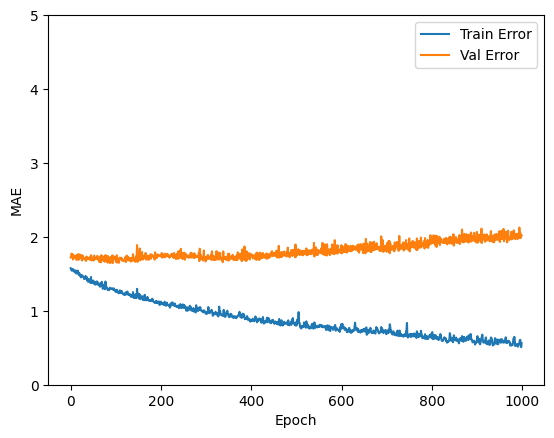

In [101]:
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.plot(df_hist['epoch'], df_hist['mae'], label=['Train Error'] )
plt.plot(df_hist['epoch'], df_hist['val_mae'], label=['Val Error'] )
plt.ylim([0,5])
plt.legend()

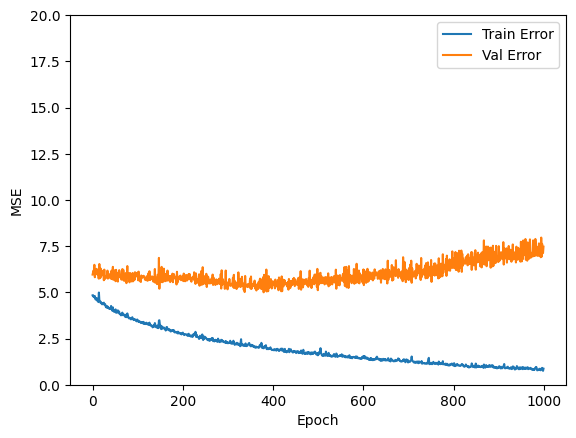

In [102]:
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.plot(df_hist['epoch'], df_hist['mse'], label=['Train Error'] )
plt.plot(df_hist['epoch'], df_hist['val_mse'], label=['Val Error'] )
plt.ylim([0,20])
plt.legend()

In [103]:
def plot_history(history):
    df_hist = pd.DataFrame(history.history)
    df_hist['epoch'] = history.epoch
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.plot(df_hist['epoch'], df_hist['mae'], label=['Train Error'] )
    plt.plot(df_hist['epoch'], df_hist['val_mae'], label=['Val Error'] )
    plt.legend()
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.plot(df_hist['epoch'], df_hist['mse'], label=['Train Error'] )
    plt.plot(df_hist['epoch'], df_hist['val_mse'], label=['Val Error'] )
    plt.ylim([0,20])
    plt.legend()

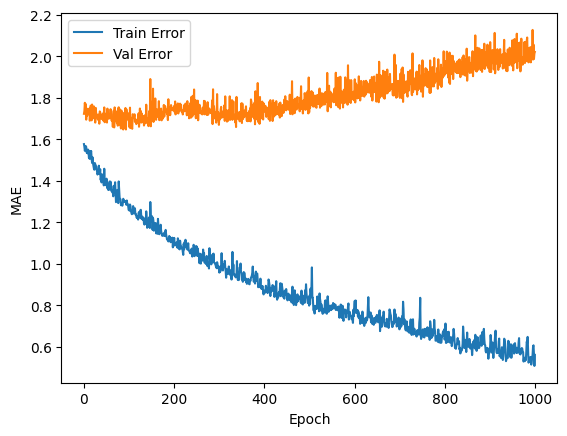

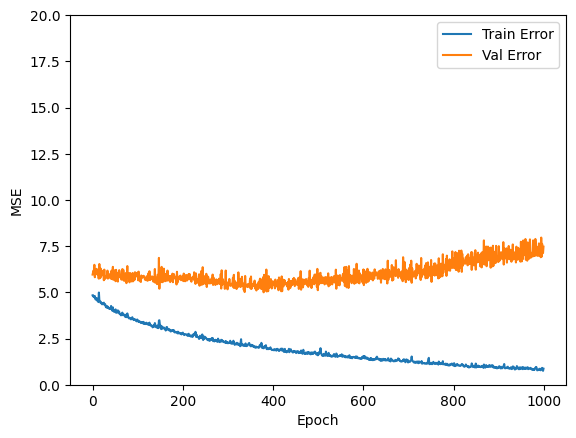

In [104]:
plot_history(history)

¿Alguna conclusión respecto a este gráfico?

Añade un early stopping al modelo. Pon el argumento `callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)]` dentro del fit().

Después del entrenamiento utiliza la función del apartado anterior `plot_history(history)`.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


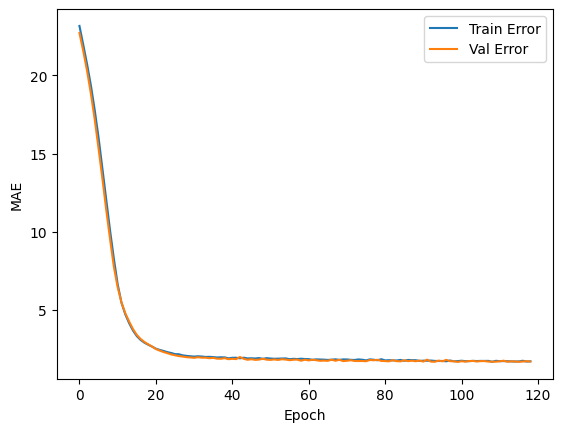

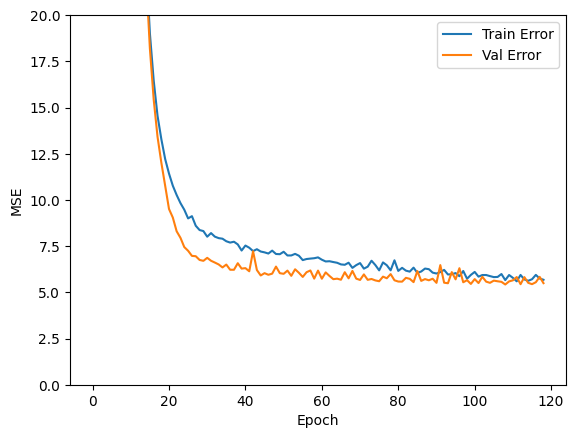

In [105]:
model = keras.Sequential([
    layers.Dense(64, activation = 'relu', input_shape = (normed_train_data.shape[1:])),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])
model.compile(loss ='mse',
              optimizer = tf.keras.optimizers.RMSprop(0.001),
              metrics = ['mae','mse'])

history = model.fit(
    normed_train_data,
    train_labels,
    epochs = 1000,
    validation_split = 0.2,
    verbose = 0,
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)]
)

plot_history(history)

Interpreta el gráfico

Veamos qué tan bien generaliza el modelo al usar el conjunto de **test**. Esto nos dice qué tan bien podemos esperar que el modelo prediga cuándo lo usamos en el mundo real. Utiliza el método `evaluate` con los datos de test normalizados y sus labels.

Con el método evaluate devolverá tres valores: loss, mae y mse.

In [106]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels)
mae

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 5.4241 - mae: 1.7463 - mse: 5.4241 


1.9358093738555908

In [107]:
model.save("my_keras_model_MAE_1_96.h5")

Ahora prueba el modelo. Coge 10 ejemplos de train y llama a` model.predict`.

In [108]:
result_10 = model.predict(normed_train_data[:10])
result_10

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


array([[13.053586],
       [23.16636 ],
       [13.019098],
       [20.198872],
       [17.48339 ],
       [30.49729 ],
       [34.757965],
       [20.066227],
       [15.601147],
       [26.608007]], dtype=float32)

### Haz Predicciones

Dibuja en un scatter plot las predicciones de test vs sus true labels.

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step 


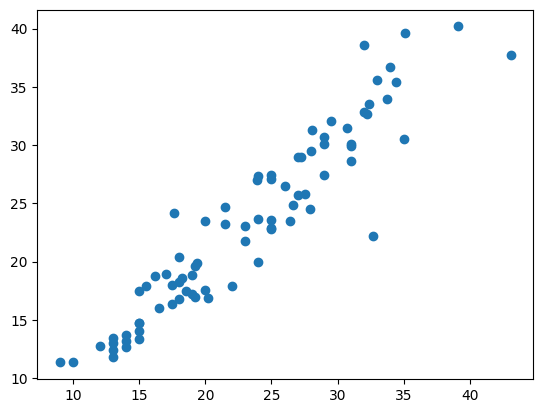

In [109]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)

Parece que nuestro modelo predice razonablemente bien. Echemos un vistazo a la distribución de errores.

Representa los residuos en un histograma

(array([ 1.,  0.,  0.,  4.,  8., 22., 21., 17.,  5.,  2.]),
 array([-10.50557137,  -8.79782295,  -7.09007406,  -5.38232565,
         -3.674577  ,  -1.96682835,  -0.25907975,   1.44866884,
          3.15641737,   4.86416626,   6.57191467]),
 <BarContainer object of 10 artists>)

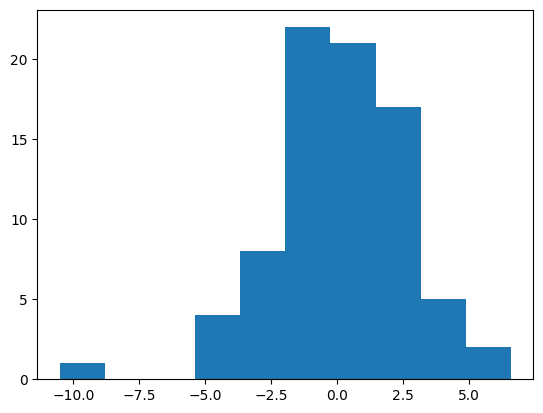

In [110]:
error = test_predictions - test_labels

plt.hist(error)

No es del todo gaussiano, pero podríamos esperar eso porque el número de muestras es muy pequeño.

## Conclusion

Este cuaderno introdujo algunas técnicas para manejar un problema de regresión.

* El error cuadrático medio (MSE) es una función de pérdida común utilizada para problemas de regresión (se utilizan diferentes funciones de pérdida para problemas de clasificación).
* Del mismo modo, las métricas de evaluación utilizadas para la regresión difieren de la clasificación. Una métrica de regresión común es el error absoluto medio (MAE).
* Cuando las características de datos de entrada numéricos tienen valores con diferentes rangos, cada característica debe escalarse independientemente al mismo rango.
* Si no hay muchos datos de entrenamiento, una técnica es preferir una red pequeña con pocas capas ocultas para evitar el sobreajuste.
* La detención temprana es una técnica útil para evitar el sobreajuste.

In [111]:
model_loaded = keras.models.load_model("my_keras_model_MAE_1_96.h5")

test_predictions = model_loaded.predict(normed_test_data).flatten()

TypeError: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}

In [44]:
test_predictions

array([15.959854 , 11.809258 , 11.608888 , 23.739529 , 21.456018 ,
       13.452995 , 13.459328 , 13.185891 , 19.566277 , 30.197691 ,
       25.139772 , 24.434137 , 14.758896 , 27.099537 , 12.689086 ,
       14.1606865, 14.756001 , 13.51071  , 18.882006 , 12.879957 ,
       13.7637005, 26.122679 , 19.916225 , 20.633533 , 29.98501  ,
       24.111109 , 16.20769  , 22.777466 , 17.006292 , 18.20529  ,
       28.178366 , 21.969866 , 18.92736  , 21.148462 , 27.137497 ,
       15.942303 , 19.165396 , 31.352602 , 30.45122  , 17.699923 ,
       31.231674 , 29.20478  , 15.917363 , 36.987144 , 35.3077   ,
       36.589806 , 20.384377 , 22.27115  , 20.109816 , 25.79674  ,
       31.362179 , 18.753128 , 32.70923  , 19.180439 , 18.488049 ,
       18.481604 , 33.337845 , 35.812485 , 22.335962 , 24.958067 ,
       39.508484 , 33.77723  , 27.741447 , 28.67013  , 32.379013 ,
       40.749245 , 37.772156 , 35.85453  , 33.42369  , 31.257288 ,
       23.182585 , 23.119347 , 29.98371  , 30.534584 , 35.9730